# Quick intro

This is a jupyter notebook for testing / coding. So far, each code block is a separate test; unlike an ordinary notebook, they are not meant to run sequentially.

First, test to see jupyter is running correctly at all:


In [1]:
import os
import sys

print("hi!!! you")

hi!!! you


Do grads apply through hessians?

In [21]:
import myhessian
import torch
ts = torch.tensor
t = ts([i+.5 for i in range(5)], requires_grad=True)
l = torch.sum(t**3)
[lg] = torch.autograd.grad(l,t,create_graph=True,retain_graph=True)
[lgg] = torch.autograd.grad(lg[1],t,create_graph=True,retain_graph=True)
lgg2 = lgg.contiguous().view(-1)
print(lgg2.size())
lgg3 = torch.zeros(6,6)#,requires_grad=True)
lgg3[1,1:].add_(lgg2.type_as(lgg3))
print(lg)
h = myhessian.hessian(l,t)
l2 = torch.sum(lgg3)
l2.backward()
print(t.grad)
print(lgg3.requires_grad)

torch.Size([5])
tensor([ 0.7500,  6.7500, 18.7500, 36.7500, 60.7500], grad_fn=<MulBackward0>)
tensor([0., 6., 0., 0., 0.])
True


Can you add grads post-hoc?

In [25]:
from torch import *

t1 = torch.tensor(1., requires_grad=True)
t1b = t1.detach().requires_grad_()
t2 = 2 * t1b
t3 = t2 * t1
print(t2.grad_fn)
temp = t2.grad_fn
#t2.grad_fn = None
t3.backward(retain_graph=True)
print(t1.grad)
t3.backward(retain_graph=True)
print(t1.grad)
#t2.requires_grad = False
t3.backward(retain_graph=True)
print(t1.grad)
#t2.requires_grad = True
t3.backward(retain_graph=True)
print(t1.grad)
t1.grad = t1.grad + t1b.grad
print(t1.grad)
t3.backward(retain_graph=True)
print(t1.grad)
t3.extra_attr = 3
print(t3.extra_attr)


tensor(2.)
tensor(4.)
tensor(6.)
tensor(8.)
tensor(16.)
tensor(18.)
3


Do I have the Euler constant right?

In [17]:
import pyro
from pyro import distributions as dist
import torch

EULER_CONSTANT = 0.5772156649015328606065120900824024310421
gd = dist.Gumbel(torch.tensor(-EULER_CONSTANT),torch.tensor(1.))
print(gd.sample())
torch.mean(gd.sample([1000000]))


tensor(-1.3647)


tensor(0.0003)

Does the "linearize then delinearize" trick work?

In [1]:
import torch
import myhessian

t1 = torch.ones(2,2,requires_grad = True)
ys = []
ws = []
y2 = []
for i in range(5):
    ys.append(torch.ones(1,requires_grad = True) * i)
    ws.append(ys[i] * (i+1))
    y2.append(ws[i] / (i+1))
    
y = torch.cat(y2,0)
output = torch.sum(t1**2) + torch.sum(y**2)


hess,grad = myhessian.hessian(output,[t1]+ws,return_grad=True,allow_unused=True)

print(hess,grad) 
#good graph

t1 = torch.ones(2,2,requires_grad = True)
ys = []
ws = []
y2 = []
for i in range(5):
    ys.append(torch.ones(1,requires_grad = True) * i)
    ws.append(ys[i] * (i+1))
    y2.append(ws[i] / (i+1))
    
y = torch.cat(ys,0)
output = torch.sum(t1**2) + torch.sum(y**2)

hess,grad = myhessian.hessian(output,[t1]+ws,return_grad=True,allow_unused=True)

print(hess,grad) #bad graph too sparse

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2222, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0800]],
       grad_fn=<CopySlices>) tensor([2.0000, 2.0000, 2.0000, 2.0000, 0.0000, 1.0000, 1.3333, 1.5000, 1.6000],
       grad_fn=<CatBackward>)
tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 

What do the values mean in format_shapes?

In [11]:
import os
import torch
import pyro
from torch.distributions import constraints
from pyro.distributions import Bernoulli, Categorical, MultivariateNormal, Multinomial, Normal
from pyro.distributions.util import broadcast_shape
from pyro.infer import Trace_ELBO, TraceEnum_ELBO, config_enumerate
import pyro.poutine as poutine
from pyro.optim import Adam

# We'll ue this helper to check our models are correct.
def test_model(model, guide, loss):
    pyro.clear_param_store()
    loss.loss(model, guide)
    
def model1():
    a = pyro.sample("a", Normal(0, 1))
    b = pyro.sample("b", Normal(torch.zeros(2), 1).to_event(1))
    with pyro.plate("c_plate", 2):
        c = pyro.sample("c", Normal(torch.zeros(2), 1))
    with pyro.plate("d_plate", 3):
        d = pyro.sample("d", Multinomial(5,torch.ones(3,4,5)).to_event(1))
    assert a.shape == ()       # batch_shape == ()     event_shape == ()
    assert b.shape == (2,)     # batch_shape == ()     event_shape == (2,)
    assert c.shape == (2,)     # batch_shape == (2,)   event_sahpe == ()
    assert d.shape == (3,4,5)  # batch_shape == (3,)   event_shape == (4,5)

    x_axis = pyro.plate("x_axis", 3, dim=-2)
    y_axis = pyro.plate("y_axis", 2, dim=-3)
    with x_axis:
        x = pyro.sample("x", Normal(0, 1))
    with y_axis:
        y = pyro.sample("y", Normal(0, 1))
    with x_axis, y_axis:
        xy = pyro.sample("xy", Normal(0, 1))
        z = pyro.sample("z", Normal(0, 1).expand([5]).to_event(1))
    assert x.shape == (3, 1)        # batch_shape == (3,1)     event_shape == ()
    assert y.shape == (2, 1, 1)     # batch_shape == (2,1,1)   event_shape == ()
    assert xy.shape == (2, 3, 1)    # batch_shape == (2,3,1)   event_shape == ()
    assert z.shape == (2, 3, 1, 5)  # batch_shape == (2,3,1)   event_shape == (5,)

test_model(model1, model1, Trace_ELBO())

trace = poutine.trace(model1).get_trace()
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

Trace Shapes:            
 Param Sites:            
Sample Sites:            
       a dist       |    
        value       |    
     log_prob       |    
       b dist       | 2  
        value       | 2  
     log_prob       |    
 c_plate dist       |    
        value     2 |    
     log_prob       |    
       c dist     2 |    
        value     2 |    
     log_prob     2 |    
 d_plate dist       |    
        value     3 |    
     log_prob       |    
       d dist     3 | 4 5
        value     3 | 4 5
     log_prob     3 |    
  x_axis dist       |    
        value     3 |    
     log_prob       |    
  y_axis dist       |    
        value     2 |    
     log_prob       |    
       x dist   3 1 |    
        value   3 1 |    
     log_prob   3 1 |    
       y dist 2 1 1 |    
        value 2 1 1 |    
     log_prob 2 1 1 |    
      xy dist 2 3 1 |    
        value 2 3 1 |    
     log_prob 2 3 1 |    
       z dist 2 3 1 | 5  
        value 2 3 1 | 5  
     log_pro

Does my gumbel MLE function work?

hi
tensor([0.]) tensor([0.5671]) tensor([2.8609])
hi
tensor([0.9984]) tensor([0.3248]) tensor([-0.3759]) tensor([1.3285]) tensor([-1.9346])
getMLE seems to have failed, tensor([0.7007]) tensor([0.3248]) tensor([-0.3759]) tensor([0.9984]) tensor([1.3285]) tensor([-1.9346]) 0.0001 tensor([-4.6848]) tensor([-4.6855])
0.7006621956825256


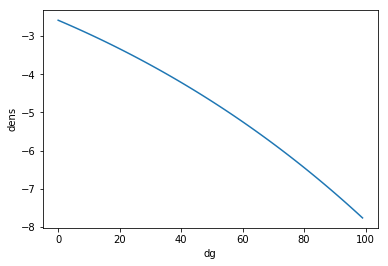

tensor([-1.1023]) tensor([1.2449]) tensor([0.7798]) tensor([-0.3877]) tensor([-1.0191])
getMLE seems to have failed, tensor([2.0247]) tensor([1.2449]) tensor([0.7798]) tensor([-1.1023]) tensor([-0.3877]) tensor([-1.0191]) 0.0001 tensor([-2.7161]) tensor([-2.7163])
2.0247223377227783


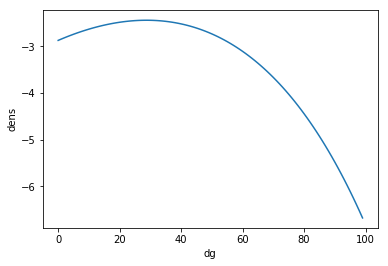

tensor([-0.1526]) tensor([0.1477]) tensor([-0.5655]) tensor([-0.1449]) tensor([0.2975])
getMLE seems to have failed, tensor([0.7132]) tensor([0.1477]) tensor([-0.5655]) tensor([-0.1526]) tensor([-0.1449]) tensor([0.2975]) -0.0001 tensor([0.5131]) tensor([0.5130])
0.7131592631340027


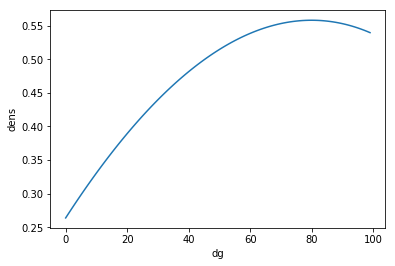

tensor([-0.0403]) tensor([0.3199]) tensor([0.1385]) tensor([0.1039]) tensor([-0.6812])
getMLE seems to have failed, tensor([0.4584]) tensor([0.3199]) tensor([0.1385]) tensor([-0.0403]) tensor([0.1039]) tensor([-0.6812]) 0.0001 tensor([0.8972]) tensor([0.8970])
0.45838138461112976


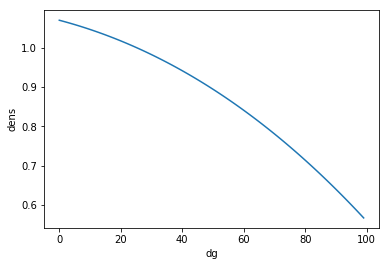

tensor([0.8538]) tensor([1.2840]) tensor([2.5180]) tensor([0.2752]) tensor([0.2549])
getMLE seems to have failed, tensor([3.8020]) tensor([1.2840]) tensor([2.5180]) tensor([0.8538]) tensor([0.2752]) tensor([0.2549]) 0.0001 tensor([-3.1602]) tensor([-3.1602])
3.8020143508911133


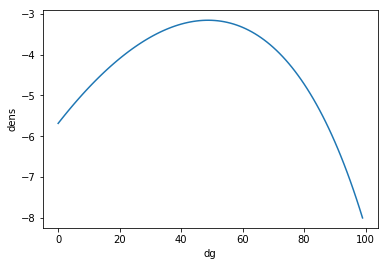

tensor([-0.5102]) tensor([0.3971]) tensor([-0.2596]) tensor([-0.9859]) tensor([0.5864])
getMLE seems to have failed, tensor([0.6568]) tensor([0.3971]) tensor([-0.2596]) tensor([-0.5102]) tensor([-0.9859]) tensor([0.5864]) -0.0001 tensor([-0.2757]) tensor([-0.2758])
0.6567732095718384


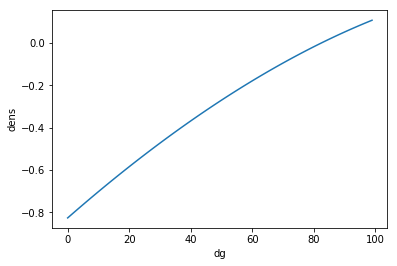

tensor([-1.1262]) tensor([1.0309]) tensor([0.7952]) tensor([-0.4274]) tensor([-1.1057])
getMLE seems to have failed, tensor([1.8262]) tensor([1.0309]) tensor([0.7952]) tensor([-1.1262]) tensor([-0.4274]) tensor([-1.1057]) 0.0001 tensor([-2.7273]) tensor([-2.7275])
1.8261679410934448


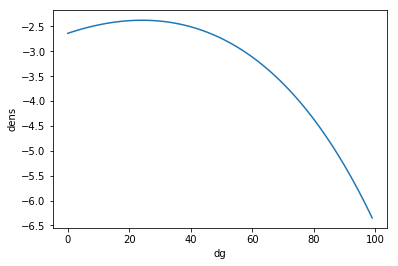

tensor([-0.0767]) tensor([0.0704]) tensor([0.0182]) tensor([-0.8866]) tensor([-1.0056])
getMLE seems to have failed, tensor([0.0886]) tensor([0.0704]) tensor([0.0182]) tensor([-0.0767]) tensor([-0.8866]) tensor([-1.0056]) 0.0001 tensor([3.6182]) tensor([3.6181])
0.08861923962831497


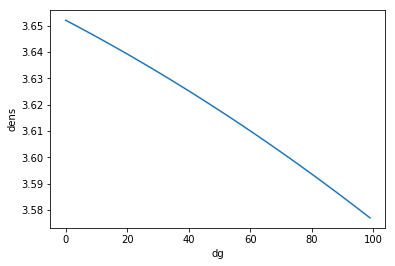

tensor([-0.8268]) tensor([0.7770]) tensor([-0.0919]) tensor([-1.1157]) tensor([-0.5587])
getMLE seems to have failed, tensor([0.8689]) tensor([0.7770]) tensor([-0.0919]) tensor([-0.8268]) tensor([-1.1157]) tensor([-0.5587]) -0.0001 tensor([-0.0922]) tensor([-0.0922])
0.8689103126525879


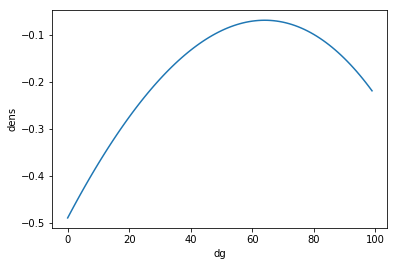

tensor([-0.0496]) tensor([1.2298]) tensor([2.0899]) tensor([0.2064]) tensor([-0.1862])
getMLE seems to have failed, tensor([3.3197]) tensor([1.2298]) tensor([2.0899]) tensor([-0.0496]) tensor([0.2064]) tensor([-0.1862]) 0.0001 tensor([-2.9027]) tensor([-2.9027])
3.3196685314178467


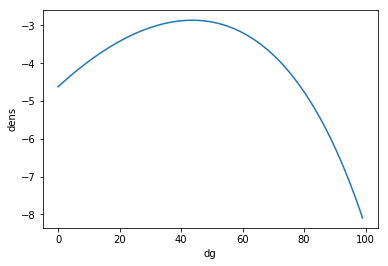

tensor([0.8758]) tensor([0.1614]) tensor([-1.0257]) tensor([0.0486]) tensor([-1.0854])
getMLE seems to have failed, tensor([1.1871]) tensor([0.1614]) tensor([-1.0257]) tensor([0.8758]) tensor([0.0486]) tensor([-1.0854]) 0.0001 tensor([-0.9971]) tensor([-0.9973])
1.1871156692504883


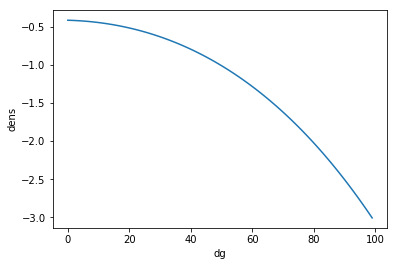

tensor([3.2105]) tensor([0.3948]) tensor([0.9152]) tensor([0.4226]) tensor([4.2654])
getMLE seems to have failed, tensor([1.3099]) tensor([0.3948]) tensor([0.9152]) tensor([3.2105]) tensor([0.4226]) tensor([4.2654]) -0.0001 tensor([-4.2696]) tensor([-4.2696])
1.3099498748779297


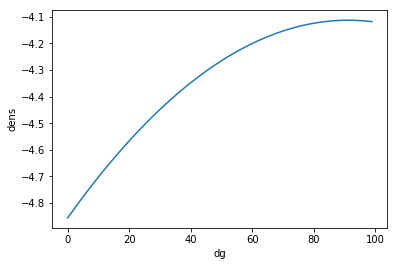

tensor([-1.0607]) tensor([0.2204]) tensor([-1.3492]) tensor([-0.1207]) tensor([0.9830])
getMLE seems to have failed, tensor([1.5696]) tensor([0.2204]) tensor([-1.3492]) tensor([-1.0607]) tensor([-0.1207]) tensor([0.9830]) -0.0001 tensor([-1.0705]) tensor([-1.0706])
1.5695935487747192


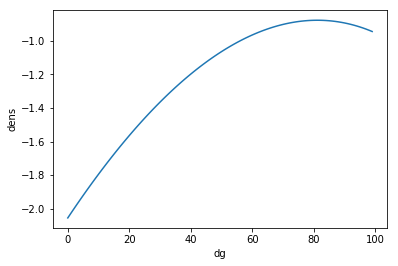

getMLE: replacing nans


RuntimeError: output with shape [] doesn't match the broadcast shape [1]

<Figure size 432x288 with 0 Axes>

In [2]:
from importlib import reload
import demoGumbel #import *
reload(demoGumbel)
from demoGumbel import *
import cProfile as profile

print("hi")

print(lambertw(ts([0.])),lambertw(ts([1.])),lambertw(ts([50.])))
print("hi")

testMLE()

Does my T MLE function work?

tensor([0.9984]) tensor([0.3230]) tensor([0.3777]) tensor([0.3186]) tensor([0.6798])
getMLE seems to have failed, tensor([0.7007]) tensor([0.3230]) tensor([0.3777]) tensor([0.9984]) tensor([0.3186]) tensor([0.6798]) -0.0001 tensor([-1.7672]) tensor([-1.7672])
0.7006621956825256


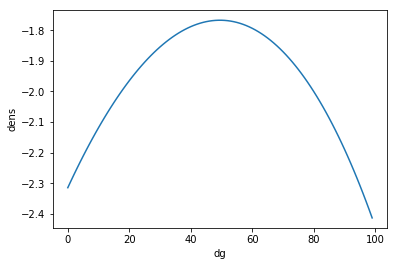

tensor([-1.1023]) tensor([0.3735]) tensor([1.6513]) tensor([-0.0626]) tensor([-1.0397])
getMLE seems to have failed, tensor([2.0247]) tensor([0.3735]) tensor([1.6513]) tensor([-1.1023]) tensor([-0.0626]) tensor([-1.0397]) 0.0001 tensor([-1.6987]) tensor([-1.6987])
2.0247223377227783


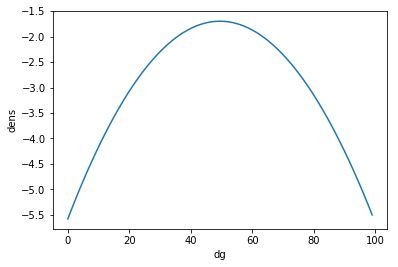

tensor([-0.1526]) tensor([0.3836]) tensor([0.3296]) tensor([-0.0979]) tensor([-0.0547])
getMLE seems to have failed, tensor([0.7132]) tensor([0.3836]) tensor([0.3296]) tensor([-0.1526]) tensor([-0.0979]) tensor([-0.0547]) 0.0001 tensor([0.0975]) tensor([0.0975])
0.7131592631340027


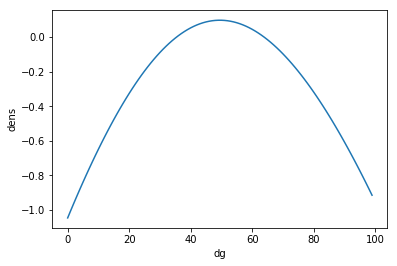

getMLE seems to have failed, tensor([0.7132]) tensor([0.3836]) tensor([0.3296]) tensor([-0.1526]) tensor([-0.0979]) tensor([-0.0547]) -0.0001 tensor([0.0975]) tensor([0.0975])
0.7131592631340027


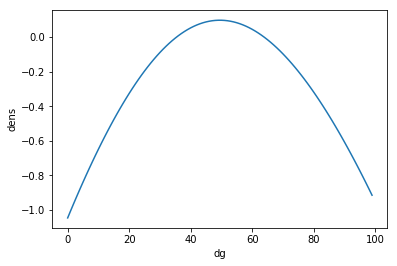

tensor([-0.0403]) tensor([0.0960]) tensor([0.3624]) tensor([-0.0034]) tensor([-0.0369])
getMLE seems to have failed, tensor([0.4584]) tensor([0.0960]) tensor([0.3624]) tensor([-0.0403]) tensor([-0.0034]) tensor([-0.0369]) 0.0001 tensor([1.4314]) tensor([1.4314])
0.45838138461112976


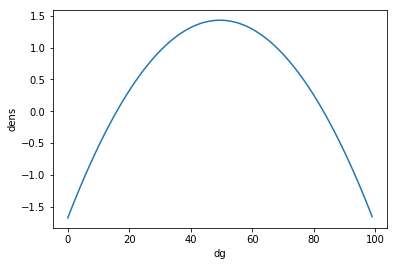

getMLE seems to have failed, tensor([0.4584]) tensor([0.0960]) tensor([0.3624]) tensor([-0.0403]) tensor([-0.0034]) tensor([-0.0369]) -0.0001 tensor([1.4314]) tensor([1.4314])
0.45838138461112976


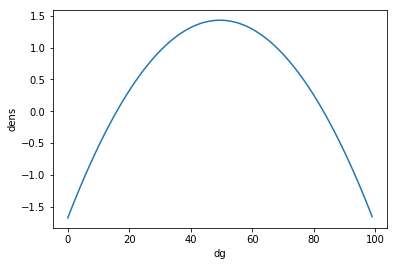

tensor([0.8538]) tensor([0.3852]) tensor([3.4168]) tensor([0.0140]) tensor([0.8398])
tensor([-0.5102]) tensor([0.2749]) tensor([0.3818]) tensor([-0.1820]) tensor([-0.3282])
getMLE seems to have failed, tensor([0.6568]) tensor([0.2749]) tensor([0.3818]) tensor([-0.5102]) tensor([-0.1820]) tensor([-0.3282]) 0.0001 tensor([-0.3253]) tensor([-0.3253])
0.6567732095718384


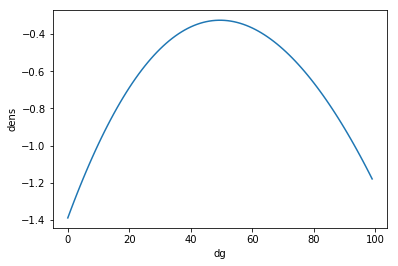

getMLE seems to have failed, tensor([0.6568]) tensor([0.2749]) tensor([0.3818]) tensor([-0.5102]) tensor([-0.1820]) tensor([-0.3282]) -0.0001 tensor([-0.3253]) tensor([-0.3253])
0.6567732095718384


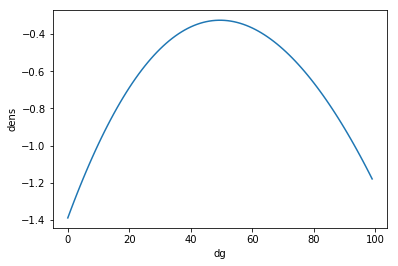

tensor([-1.1262]) tensor([0.3093]) tensor([1.5169]) tensor([-0.0510]) tensor([-1.0752])
tensor([-0.0767]) tensor([0.0211]) tensor([0.0675]) tensor([-0.0067]) tensor([-0.0700])
getMLE seems to have failed, tensor([0.0886]) tensor([0.0211]) tensor([0.0675]) tensor([-0.0767]) tensor([-0.0067]) tensor([-0.0700]) 0.0001 tensor([3.9705]) tensor([3.9705])
0.08861923962831497


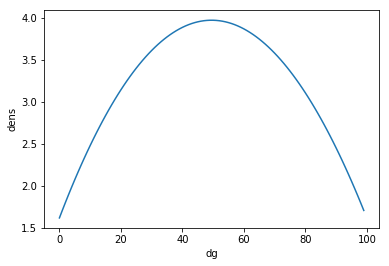

getMLE seems to have failed, tensor([0.0886]) tensor([0.0211]) tensor([0.0675]) tensor([-0.0767]) tensor([-0.0067]) tensor([-0.0700]) -0.0001 tensor([3.9705]) tensor([3.9705])
0.08861923962831497


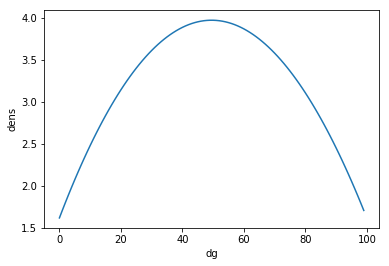

tensor([-0.8268]) tensor([0.2883]) tensor([0.5807]) tensor([-0.1528]) tensor([-0.6740])
tensor([-0.0496]) tensor([0.3689]) tensor([2.9507]) tensor([-0.0010]) tensor([-0.0486])
tensor([0.8758]) tensor([0.6638]) tensor([0.5233]) tensor([0.5775]) tensor([0.2983])
getMLE seems to have failed, tensor([1.1871]) tensor([0.6638]) tensor([0.5233]) tensor([0.8758]) tensor([0.5775]) tensor([0.2983]) 0.0001 tensor([-1.4466]) tensor([-1.4466])
1.1871156692504883


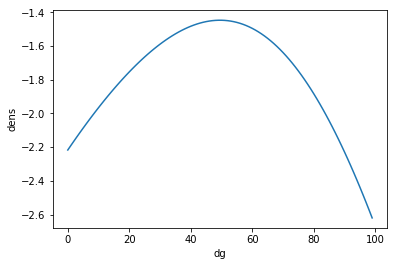

getMLE seems to have failed, tensor([1.1871]) tensor([0.6638]) tensor([0.5233]) tensor([0.8758]) tensor([0.5775]) tensor([0.2983]) -0.0001 tensor([-1.4466]) tensor([-1.4466])
1.1871156692504883


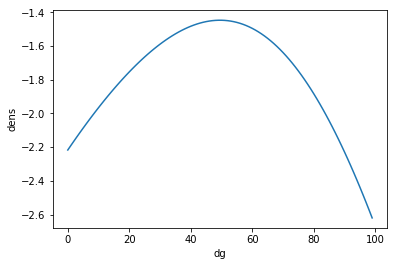

tensor([3.2105]) tensor([0.1184]) tensor([1.1915]) tensor([0.0124]) tensor([3.1981])
getMLE seems to have failed, tensor([1.3099]) tensor([0.1184]) tensor([1.1915]) tensor([3.2105]) tensor([0.0124]) tensor([3.1981]) 0.0001 tensor([-2.4154]) tensor([-2.4154])
1.3099498748779297


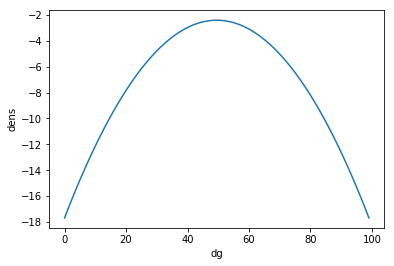

tensor([-1.0607]) tensor([0.8756]) tensor([0.6939]) tensor([-0.7010]) tensor([-0.3598])
tensor([0.1228]) tensor([0.0941]) tensor([0.2039]) tensor([0.0256]) tensor([0.0971])
getMLE seems to have failed, tensor([0.2980]) tensor([0.0941]) tensor([0.2039]) tensor([0.1228]) tensor([0.0256]) tensor([0.0971]) 0.0001 tensor([1.8510]) tensor([1.8510])
0.29795295000076294


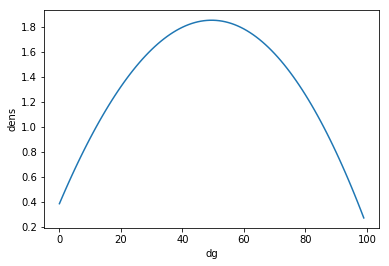

getMLE seems to have failed, tensor([0.2980]) tensor([0.0941]) tensor([0.2039]) tensor([0.1228]) tensor([0.0256]) tensor([0.0971]) -0.0001 tensor([1.8510]) tensor([1.8510])
0.29795295000076294


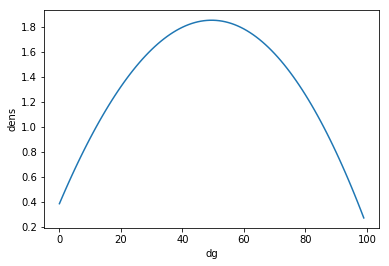

tensor([0.5236]) tensor([0.0107]) tensor([0.5262]) tensor([0.0002]) tensor([0.5234])
getMLE seems to have failed, tensor([0.5368]) tensor([0.0107]) tensor([0.5262]) tensor([0.5236]) tensor([0.0002]) tensor([0.5234]) 0.0001 tensor([2.6916]) tensor([2.6915])
0.536840558052063


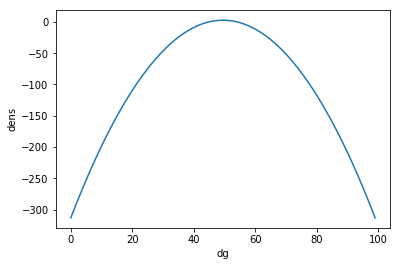

getMLE seems to have failed, tensor([0.5368]) tensor([0.0107]) tensor([0.5262]) tensor([0.5236]) tensor([0.0002]) tensor([0.5234]) -0.0001 tensor([2.6916]) tensor([2.6915])
0.536840558052063


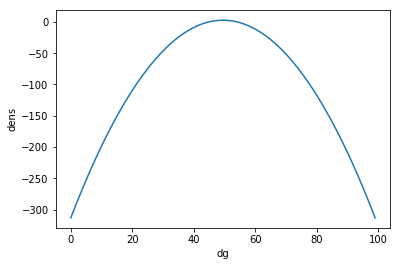

tensor([-1.0893]) tensor([0.6937]) tensor([0.7241]) tensor([-0.5541]) tensor([-0.5352])
getMLE seems to have failed, tensor([1.4178]) tensor([0.6937]) tensor([0.7241]) tensor([-1.0893]) tensor([-0.5541]) tensor([-0.5352]) 0.0001 tensor([-1.8849]) tensor([-1.8849])
1.417846918106079


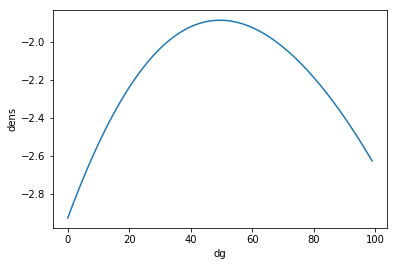

tensor([-1.0250]) tensor([0.3699]) tensor([0.9093]) tensor([-0.1477]) tensor([-0.8773])
tensor([-0.0013]) tensor([0.0012]) tensor([0.0017]) tensor([-0.0005]) tensor([-0.0008])
getMLE seems to have failed, tensor([0.0029]) tensor([0.0012]) tensor([0.0017]) tensor([-0.0013]) tensor([-0.0005]) tensor([-0.0008]) 0.0001 tensor([10.9382]) tensor([10.9331])
0.002937753451988101


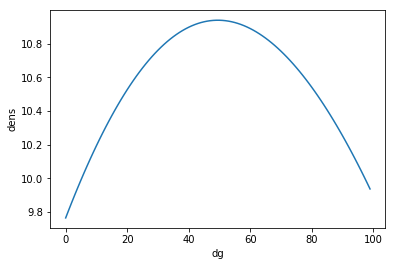

getMLE seems to have failed, tensor([0.0029]) tensor([0.0012]) tensor([0.0017]) tensor([-0.0013]) tensor([-0.0005]) tensor([-0.0008]) -0.0001 tensor([10.9382]) tensor([10.9330])
0.002937753451988101


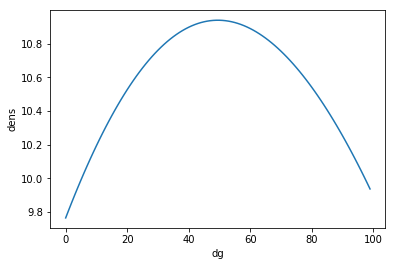

tensor([-0.0860]) tensor([0.0222]) tensor([0.1578]) tensor([-0.0020]) tensor([-0.0840])
getMLE seems to have failed, tensor([0.1800]) tensor([0.0222]) tensor([0.1578]) tensor([-0.0860]) tensor([-0.0020]) tensor([-0.0840]) 0.0001 tensor([3.5492]) tensor([3.5492])
0.1800323873758316


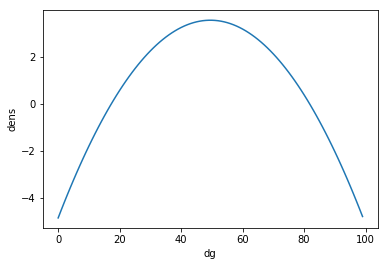

getMLE seems to have failed, tensor([0.1800]) tensor([0.0222]) tensor([0.1578]) tensor([-0.0860]) tensor([-0.0020]) tensor([-0.0840]) -0.0001 tensor([3.5492]) tensor([3.5492])
0.1800323873758316


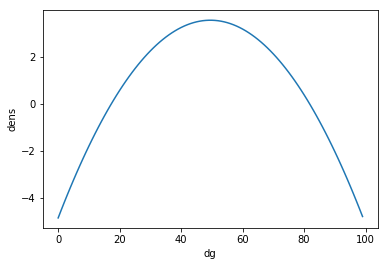

tensor([0.9182]) tensor([0.2013]) tensor([1.9849]) tensor([0.0116]) tensor([0.9066])
getMLE seems to have failed, tensor([2.1862]) tensor([0.2013]) tensor([1.9849]) tensor([0.9182]) tensor([0.0116]) tensor([0.9066]) 0.0001 tensor([-1.1385]) tensor([-1.1385])
2.1861608028411865


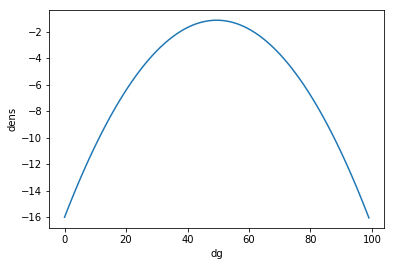

getMLE seems to have failed, tensor([2.1862]) tensor([0.2013]) tensor([1.9849]) tensor([0.9182]) tensor([0.0116]) tensor([0.9066]) -0.0001 tensor([-1.1385]) tensor([-1.1385])
2.1861608028411865


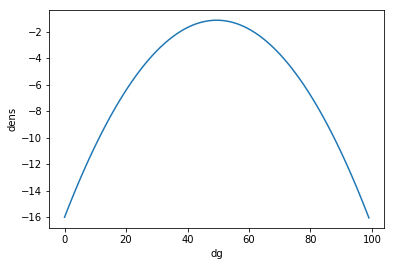

<Figure size 432x288 with 0 Axes>

In [22]:
from importlib import reload
import demoT #import *
reload(demoT)
from demoT import *
import cProfile as profile


testMLE()

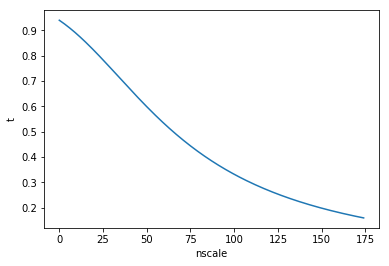

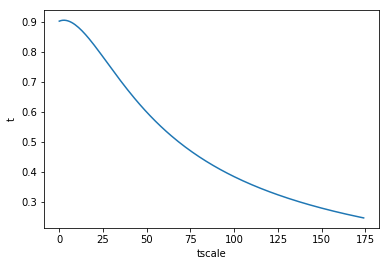

assert approx_eq( tensor(32.6871) tensor(-35.1676) tensor(12.7895) tensor(-10.3200) tensor(-0.0110)
assert approx_eq( tensor(33.4056) tensor(-35.8885) tensor(12.8825) tensor(-10.3800) tensor(0.0196)
assert approx_eq( tensor(33.8249) tensor(-36.3974) tensor(12.9362) tensor(-10.4400) tensor(-0.0763)


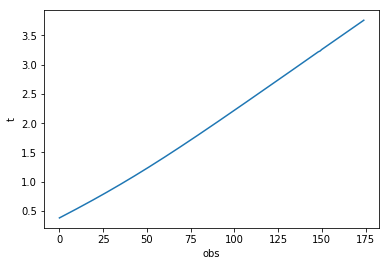

<Figure size 432x288 with 0 Axes>

In [21]:
from importlib import reload
import demoT #import *
reload(demoT)
from demoT import *
import cProfile as profile


plotMLE()

draw some ellipses:


Ellipse(xy=(0, 0), width=2.0, height=2.0, angle=0)
hi


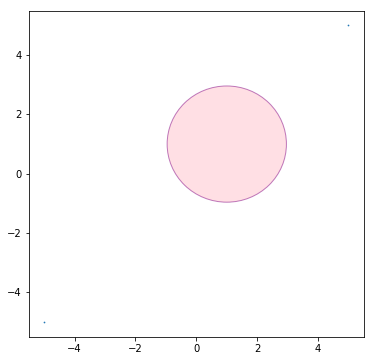

In [8]:
from draw_ellipses import *
import torch


fig, ax = plt.subplots(figsize=(6, 6))
lims = [-5,5]
ax.scatter(lims, lims, s=0.5)

confidence_ellipse(torch.ones(2),torch.eye(2),ax,alpha=0.5, facecolor='pink', edgecolor='purple', zorder=0)
print("hi")
plt.show()

running...
/anaconda3/bin/python
Then:
0 1 ['amortized_laplace', 'meanfield'] {'modal_effect': tensor(1.), 'df': tensor(3.), 't_scale': tensor(2.)}
1
testresults/scenario_N44_mu1.0_sigma2.0_nu3.0.csv from file
44
tensor([-1.6036,  3.8221,  5.2707, -0.7136])
guidename amortized_laplace
trueparams {'modal_effect': tensor(1.), 'df': tensor(3.), 't_scale': tensor(2.)}
esize torch.Size([44])
epoch 0 loss = 245.6659381389618;
mode_hat tensor(-0.0050, requires_grad=True)
ltscale_hat tensor(0.0050, requires_grad=True)
ldfraw_hat tensor(-0.0050, requires_grad=True)
complaint 9 assert approx_eq( tensor([-3.6782e+00,  5.6605e+01,  1.4723e+02, -3.0780e-01,  1.2546e-01,
         1.6358e+02, -3.7099e+01,  1.4832e+02, -2.2210e+02, -7.9500e+02,
         3.1716e+02,  9.3401e+02, -1.2950e-02, -7.9922e+00,  1.5807e+02,
        -7.3586e+01,  1.0327e+02, -1.8776e-02,  2.0324e+03,  2.5630e+01,
         2.0976e+01,  4.4956e+02,  5.3311e-04,  7.5418e-02,  4.2796e+02,
         9.8390e+02,  3.2141e+03,  7.8752e

Final mean_losses: 110.98339816680405
save_data {'modal_effect': tensor(0.1550, requires_grad=True), 't_scale_raw': tensor(0.1030, requires_grad=True), 't_part': tensor([0.6635, 0.9446, 0.8647, 0.8881, 0.7374, 0.8211, 0.6909, 0.7247],
       grad_fn=<IndexSelectBackward>), 'hessian': tensor([[13741.1035,  5623.8999,  2876.5178,  1871.0865,   700.1490,   661.8945,
           134.5162,   540.8911,  1224.9083,    99.9931],
        [ 5623.8999, 12617.5732,  2112.2742,  1954.9510,   666.7633,   647.1608,
           105.9414,   488.0749,   934.4903,    76.3502],
        [ 2876.5178,  2112.2742,  4990.1982,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [ 1871.0865,  1954.9510,     0.0000,  3827.5364,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [  700.1490,   666.7633,     0.0000,     0.0000,  1367.4137,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [  661.8945,

epoch 0 loss = 99.22640609741211;
mode_hat tensor(0.0050, requires_grad=True)
ltscale_hat tensor(0.0050, requires_grad=True)
ldfraw_hat tensor(0.0050, requires_grad=True)
Final mean_losses: 104.13965374472161
save_data {'modal_effect': tensor(0.1550, requires_grad=True), 't_scale_raw': tensor(0.1046, requires_grad=True), 't_part': tensor([0.5097, 0.6456, 0.5769, 0.7986, 0.7381, 0.7095, 0.9402, 0.9217],
       grad_fn=<IndexSelectBackward>), 'hessian': tensor([[23696.0078,  8761.0508,  6620.0605,   702.1443,  1149.8831,   669.4373,
           810.0499,  1872.7518,  2879.0781,   219.8024],
        [ 8761.0508, 19687.5723,  3742.3271,   499.4741,   732.8530,   589.0585,
           659.5849,  1470.7279,  2999.4514,   220.1783],
        [ 6620.0605,  3742.3271, 10364.4873,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [  702.1443,   499.4741,     0.0000,  1201.9509,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,  

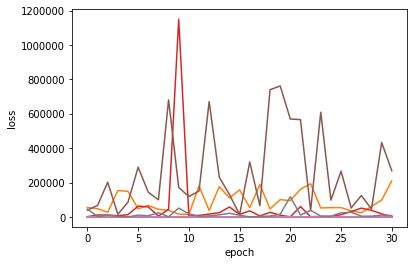

In [5]:
print("running...")

import sys, os

print(sys.executable)
#print(sys.path)

from importlib import reload
import old_code.multisiteT_frequentistDF #import *
reload(old_code.multisiteT_frequentistDF)
from old_code.multisiteT_frequentistDF import *
import cProfile as profile

print("Then:")

#vals = MIDDF35
guidenames = ["amortized_laplace","meanfield",]#,"MLE"]#,"laplace"
if True:

    for aniter in range(1):
        for nparticles in [1]:#,5]:
            for trueparams in [tdom_norm_params,ndom_norm_params,tdom_fat_params,ndom_fat_params,]:
                for guidename in guidenames:
                    #

                    print(aniter,nparticles,guidenames,trueparams)
                    result = trainGuide(guidename,nparticles,trueparams,filename="testresults/demoT_2.csv")
                    print(aniter,nparticles,guidenames)
                    for line in range(10):
                        print()
                    
else:
    plt.plot([getMLE(.01 + x/100,1.,0,1.) for x in range(500)])